# <center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 
<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 150px; display: inline"  alt="Wikistat"/></a>
<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" width=400,  style="float:right;  display: inline" alt="IMT"/> </a>
    
</center>

# Backpropagation in Multilayer Neural Networks

Reference : https://github.com/m2dsupsdlclass/lectures-labs

## What is the Backpropagation? 

Deep neural networks involve a huge number of parameters, corresponding to the weights and the biases appearing in the definition of the network. Given a training sample, all these parameters are  estimated by minimizing an empirical loss function. The function to minimize is generally very complex and  not convex. 
The minimization of the loss function is done via an optimization algorithm such as the **Stochastic Gradient Descent **(SGD) algorithm or more recent variants. All these algorithms require at each step the computation of the gradient of the loss function.  
The **backpropagation algorithm** (Rumelhart et al, 1986) is a method for **computing the gradient of the loss function**, in order to estimate the parameters of a - possibly deep - neural network. It is composed of a succession of a *forward* pass and a *backward* pass through the network in order to compute the gradient. It can be easily parallelisable. 

## Objectives

The objectives of this TP are to : 
   * Understand the theory of the backpropagation algorithm
   * Implement logistic regression and multi layers perceptron algorithms using backpropagation equations with numpy
   * Use Keras to apply the same model

## Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("whitegrid")
import numpy as np
from functools import reduce

## Dataset


The dataset we used is composed of 8x8 pixel images of hand written digits available within sklearn library.

- [sklearn.datasets.load_digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits)

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
N = reduce(lambda x,y: x*y,digits.images[0].shape)
print("Image dimension : N=%d"%N)
K = len(set(digits.target))
print("Number of classes : K=%d"%K)

Image dimension : N=64
Number of classes : K=10


### Example

(-0.5, 7.5, 7.5, -0.5)

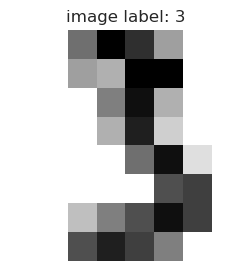

In [3]:
sample_index = 45
fig =plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1,1,1)
ax.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
ax.set_title("image label: %d" % digits.target[sample_index])
ax.grid(False)
ax.axis('off')


### Preprocessing

- Normalization
- Train / test split

In [4]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# mean = 0 ; standard deviation = 1.0
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
print("Data dimension and type")
print("X_train : " + str(X_train.shape) + ", " +str(X_train.dtype))
print("y_train : " + str(y_train.shape) + ", " +str(y_train.dtype))
print("X_test : " + str(X_test.shape) + ", " +str(X_test.dtype))
print("y_test : " + str(y_test.shape) + ", " +str(y_test.dtype))

Data dimension and type
X_train : (1527, 64), float32
y_train : (1527,), int32
X_test : (270, 64), float32
y_test : (270,), int32


## Utils Function

Write utils function that will be used later

### One-hot encoding function

$$
OneHotEncoding(N_{class},i=4) = 
\begin{bmatrix}
  0\\
  0\\
  0\\
  0\\
  1\\
  0\\
  0\\
  0\\
  0\\
  0\\
\end{bmatrix}
$$

Where $N_{class}=10$ and $i \in [0,9]$

**Exercise :** Implement the **one hot encoding** function of an integer array for a fixed number of classes (similar to keras' `to_categorical`):  
Ensure that your function works for several vectors at a time.  

In [6]:
# Write here the one_hot function
def one_hot(n_classes,y):
    ##
    return ohy

In [7]:
# %load solutions/one_hot_encoding.py
def one_hot(n_classes,y):
    ohy = np.eye(n_classes)[y]
    return ohy

Make sure the solution works on 1D array :

In [8]:
ohy = one_hot(y=3,n_classes=10)
print("Expected : [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.] \n")
print("Computed  :" + str(ohy))

Expected : [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.] 

Computed  :[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


Make sure the solution works on 2D array :

In [9]:
ohY = one_hot(n_classes=10, y=[0, 4, 9, 1])
print("Expected : [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] \n [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] \n  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] \n  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]")
print("Computed  :" + str(ohY))

Expected : [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 
  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Computed  :[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


### The softmax function

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

**Exercise :** Implement the softmax function.  
Ensure that your function works for several vectors at a time.  
Hint : use the *axis* and *keepdims* argument of the numpy function `np.sum`.

In [10]:
# keepdims option
x = np.array([[1,2,3],
              [4,5,6]])

print("Sum all elements of array :")
sx = np.sum(x)
print(sx)

print("Sum all elements over axis (dimension) :" )
sx = np.sum(x, axis=-1)
print(str(sx), str(", Dimension :") ,str(sx.shape))

print("Sum all elements over axis and with keepdims (dimension) :" )
sx = np.sum(x, axis=-1,  keepdims=True)
print(str(sx), str(", Dimension :") ,str(sx.shape))

Sum all elements of array :
21
Sum all elements over axis (dimension) :
[ 6 15] , Dimension : (2,)
Sum all elements over axis and with keepdims (dimension) :
[[ 6]
 [15]] , Dimension : (2, 1)


In [11]:
# Write here the softmax function
def softmax(x):
    ###
    return softmaxX

In [12]:
# %load solutions/softmax.py
def softmax(X):
    expX = np.exp(X)
    sumExpX = np.sum(expX, axis=-1, keepdims=True)
    softmaxX = expX/sumExpX
    return softmaxX

Make sure that your function works for a 1D array :

In [13]:
x = [10, 2, -3]
sx = softmax(x)
print("Expected : [9.99662391e-01 3.35349373e-04 2.25956630e-06]")
print("Computed " + str(sx))
print("Value Sum to one : %d" %np.sum(sx))

Expected : [9.99662391e-01 3.35349373e-04 2.25956630e-06]
Computed [9.99662391e-01 3.35349373e-04 2.25956630e-06]
Value Sum to one : 1


Make sure that your function works for a  2D array :

In [14]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
sX = softmax(X)
print("Expected : [[9.99662391e-01 3.35349373e-04 2.25956630e-06] \n [2.47262316e-03 9.97527377e-01 1.38536042e-11]]")
print("Value found" + str(sX))
print("Value Sum to one : " + str(np.sum(sX, axis=-1)))

Expected : [[9.99662391e-01 3.35349373e-04 2.25956630e-06] 
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]
Value found[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]
Value Sum to one : [1. 1.]


### Loss function

We consider the loss function associated to the cross-entropy. Minimizing this loss function corresponds to minimization of the negative log likelihood  (which is equivalent to the  maximization of the log likelihood).

According to course's notations, we have 
$$ \ell(f(x),y) = -\log (f(x))_y = -  \sum_{k=1}^K  \mathbb{1}_{y=k} \log (f(x))_k
$$

where $(f(x))_k =  \mathbb{P}(Y=k~/~x)$, the predicted probability for the class $k$, when the input equals $x$. 


**Exercice**:  
Write a function that computes the mean negative likelihood (empirical loss) of a group of observations `Y_true` and `Fx`, where `Y_true` and `Fx` are respectively the one-hot encoded representation of the observed labels and the predictions for the associated inputs $x$ i.e. :

* `Y_true` is the one-hot encoded representation of $y$
* `Fx` is the output of a softmax function.

In [15]:
# Write here the negative_log_likelihood function
EPSILON = 1e-8
def NegLogLike(Y_true, Fx):
    ###
    return nll_mean


In [16]:
# %load solutions/negative_log_likelihood_function.py
EPSILON = 1e-8
def NegLogLike(Y_true, Fx):
    Y_prod = np.multiply(Y_true,Fx)
    Y_sum = np.sum(Y_prod, axis=-1)
    nll = -np.log(Y_sum+EPSILON)
    nll_mean = np.mean(nll)
    return nll_mean


Make sure that your implementation can compute the loss function  for a single observation. 

In [17]:
# Simple case
ohy_true = [1, 0, 0]
fx = [.99, 0.01, 0] 
nll1 = NegLogLike(ohy_true, fx)
print("A small value for the loss function :")
print("Expected value : 0.01005032575249135")
print("Computed : " + str(nll1) )

# Case with bad prediction
ohy_true = [1, 0, 0]
fx = [0.01, .99, 0] 
nll2 = NegLogLike(ohy_true, fx)
print("Higher value for the loss function):")
print("Expected value : 4.605169185988592")
print("Computed : " + str(nll2) )

A small value for the loss function :
Expected value : 0.01005032575249135
Computed : 0.01005032575249135
Higher value for the loss function):
Expected value : 4.605169185988592
Computed : 4.605169185988591


Make sure that your implementation can handle the case where $  (f(x))_y =0$.

In [18]:
# Zero case
ohy_true = [1, 0, 0]
fx = [0, 0.01, 0.99] 
nll3 = NegLogLike(ohy_true, fx)
print("Expected value : 18.420680743952367")

print("Computed : " + str(nll3) )

Expected value : 18.420680743952367
Computed : 18.420680743952364


Make sure that your implementation can compute the  empirical loss for several observations. 

In [19]:
ohY_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Fx = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

nll4 = NegLogLike(ohY_true, Fx)

print("Expected value : 0.0033501019174971905")
print("Computed : " + str(nll4) )

Expected value : 0.0033501019174971905
Computed : 0.0033501019174971905


### Sigmoid Function

- Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

In [20]:
def sigmoid(X):
    ###
    return sigX


def dsigmoid(X):
    ###
    return dsig

In [21]:
# %load solutions/sigmoid.py
def sigmoid(X):
    sigX = 1 / (1 + np.exp(-X))
    return sigX


def dsigmoid(X):
    sig=sigmoid(X)
    dsig = sig * (1 - sig)
    return dsig

Display the sigmoid function and its derivative

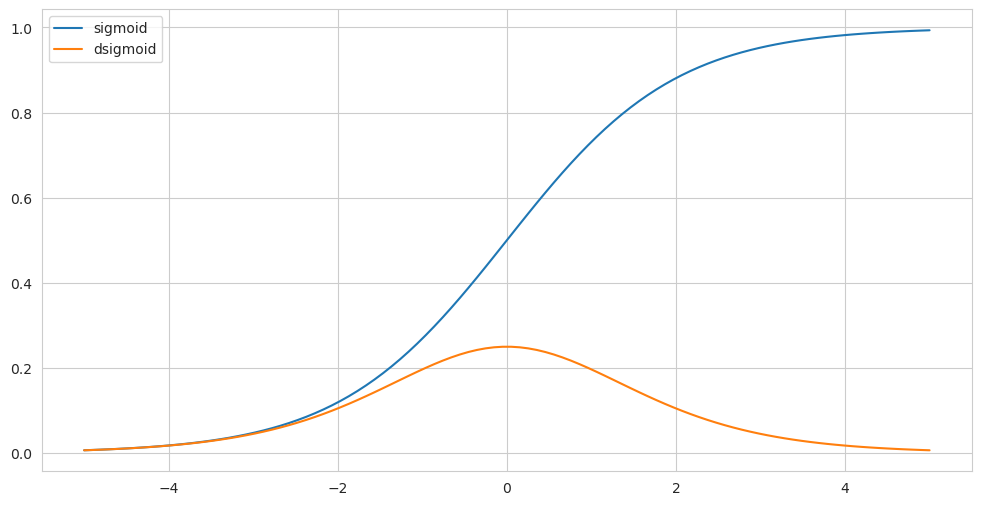

In [22]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
x = np.linspace(-5, 5, 100)
ax.plot(x, sigmoid(x), label='sigmoid')
ax.plot(x, dsigmoid(x), label='dsigmoid')
ax.legend(loc='best');

## Logistic Regression

In this section we will implement a logistic regression model trainable with SGD **one observation at a time** (On-line gradient descent).

### Implementation

Complete the `LogisticRegression` class by following these steps (Use the functions you have written above) :

**Notation** : $x \in \mathbb{R}^N$, $y \in [0,...,K]$, $W \in \mathbb{R}^{K,N}$, $b \in \mathbb{R}^K$


1.  Implement the `forward` function which computes the prediction of the model for the input $x$:  
$$f(x) = softmax(\mathbf{W} x + b)$$

2. Implement the `grad_loss` function which computes the gradient of the loss function  $  \ell(f(x),y) = -\log (f(x))_y $ (for an input $x$ and its corresponding observed output $y$) with respect to the parameters of the model $W$ and $b$ :

\begin{array}{ll} 
   grad_W &= \frac{d}{dW} [-\log (f(x))_y] \\
   grad_b &= \frac{d}{db} [-\log (f(x))_y]
\end{array}

**Hint**  
\begin{array}{ll}
    \frac{d}{dW_{i,j}} [-\log (f(x))_y] &= 
    \begin{cases}
      [f(x)_{y}-1]*x_j, & \text{if}\ i=y \\
      f(x)_{i}*x_j, & \text{otherwise}
    \end{cases} \\
    \frac{d}{db_{i}} [-\log (f(x))_y] &= 
    \begin{cases}
      f(x)_{y}-1, & \text{if}\ i=y \\
      f(x)_{i}, & \text{otherwise}
    \end{cases} \\
\end{array}
       

3. Implement the `train` function which uses the grad function output to update $\mathbf{W}$ and $b$ with traditional SGD update without momentum :
\begin{array}{ll}
W &= W - \varepsilon \frac{d}{dW} [-\log (f(x))_y]\\
b &= b - \varepsilon \frac{d}{db} [-\log (f(x))_y]
\end{array}

In [23]:
class LogisticRegression():

    def __init__(self, input_size, output_size):
        self.W = np.random.uniform(size=(input_size, output_size),
                                   high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size,
                                   high=0.1, low=-0.1)
        self.output_size = output_size
        
    def forward(self, X):
        ###
        return sZ
    

    def grad_loss(self, x, y_true):
        ###
        grads = {"W": grad_W, "b": grad_b}
        return grads
    
    def train(self, x, y, learning_rate):
        ### 
    
        
    def loss(self, x, y):
        nll = NegLogLike(one_hot(self.output_size, y), self.forward(x))
        return nll
    
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        acc = np.mean(y_preds == y)
        return acc 

IndentationError: expected an indented block after function definition on line 20 (2450581073.py, line 24)

In [24]:
# %load solutions/lr_class
class LogisticRegression():

    def __init__(self, input_size, output_size):
        self.W = np.random.uniform(size=(input_size, output_size),
                                   high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size,
                                   high=0.1, low=-0.1)
        self.output_size = output_size
        
    def forward(self, X):
        Z = np.dot(X, self.W) + self.b
        sZ = softmax(Z)
        return sZ
    
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
    
    def grad_loss(self, x, y_true):
        y_pred = self.forward(x)
        dnll_output =  y_pred - one_hot(self.output_size, y_true)
        grad_W = np.outer(x, dnll_output)
        grad_b = dnll_output
        grads = {"W": grad_W, "b": grad_b}
        return grads
    
    def train(self, x, y, learning_rate):
        # Traditional SGD update without momentum
        grads = self.grad_loss(x, y)
        self.W = self.W - learning_rate * grads["W"]
        self.b = self.b - learning_rate * grads["b"]      
        
    def loss(self, x, y):
        nll = NegLogLike(one_hot(self.output_size, y), self.forward(x))
        return nll

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        acc = np.mean(y_preds == y)
        return acc 

### Evaluate the model without training

In [25]:
# Init the model
lr = LogisticRegression(N, K)

print("Evaluation of the untrained model:")
train_loss = lr.loss(X_train, y_train)
train_acc = lr.accuracy(X_train, y_train)
test_acc = lr.accuracy(X_test, y_test)

print("train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
      % (train_loss, train_acc, test_acc))

Evaluation of the untrained model:
train loss: 2.4264, train acc: 0.074, test acc: 0.085


In [26]:
lr.W.shape

(64, 10)

Evaluate the randomly initialized model on the first example:

In [27]:
def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax0.imshow(scaler.inverse_transform(X_test[sample_idx].reshape(1,-1)).reshape(8, 8), cmap=plt.cm.gray_r,
               interpolation='nearest')
    ax0.set_title("True image label: %d" % y_test[sample_idx]);
    ax0.grid(False)
    ax0.axis('off')


    ax1.bar(classes, one_hot(len(classes), y_test[sample_idx]), label='true')
    ax1.bar(classes, model.forward(X_test[sample_idx]), label='prediction', color="red")
    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx])
    ax1.set_title('Output probabilities (prediction: %d)'
                  % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()

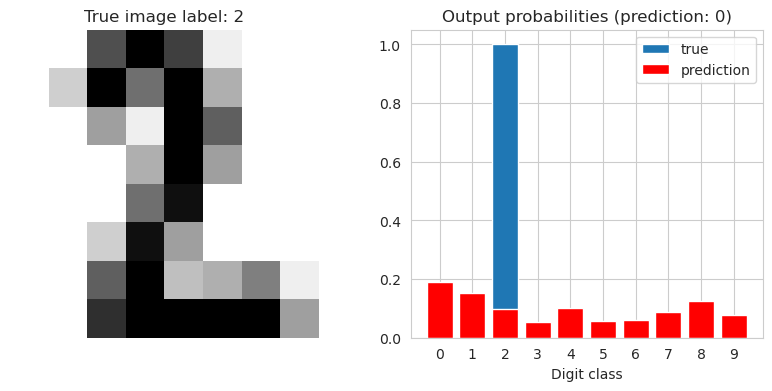

In [28]:
plot_prediction(lr, sample_idx=0)

### Train the model for one epoch

In [29]:
learning_rate = 0.01

for i, (x, y) in enumerate(zip(X_train, y_train)):
    lr.train(x, y, learning_rate)
    if i % 100 == 0:
        train_loss = lr.loss(X_train, y_train)
        train_acc = lr.accuracy(X_train, y_train)
        test_acc = lr.accuracy(X_test, y_test)
        print("Update #%d, train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
              % (i, train_loss, train_acc, test_acc))

Update #0, train loss: 2.3914, train acc: 0.096, test acc: 0.122
Update #100, train loss: 1.3219, train acc: 0.723, test acc: 0.719
Update #200, train loss: 0.8654, train acc: 0.839, test acc: 0.856
Update #300, train loss: 0.6398, train acc: 0.908, test acc: 0.900
Update #400, train loss: 0.5298, train acc: 0.909, test acc: 0.907
Update #500, train loss: 0.4610, train acc: 0.918, test acc: 0.922
Update #600, train loss: 0.4022, train acc: 0.928, test acc: 0.930
Update #700, train loss: 0.3664, train acc: 0.933, test acc: 0.933
Update #800, train loss: 0.3454, train acc: 0.936, test acc: 0.956
Update #900, train loss: 0.3208, train acc: 0.942, test acc: 0.941
Update #1000, train loss: 0.2985, train acc: 0.942, test acc: 0.948
Update #1100, train loss: 0.2807, train acc: 0.944, test acc: 0.956
Update #1200, train loss: 0.2689, train acc: 0.947, test acc: 0.967
Update #1300, train loss: 0.2615, train acc: 0.947, test acc: 0.944
Update #1400, train loss: 0.2461, train acc: 0.952, test acc

Evaluate the trained model on the first example:

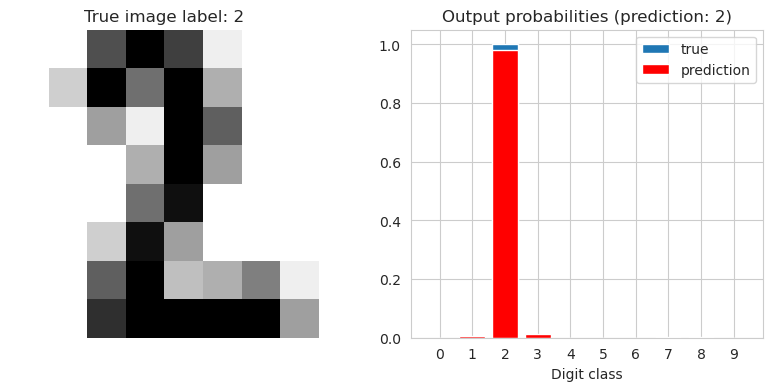

In [30]:
plot_prediction(lr, sample_idx=0)

## Multi Layer Perceptron


In this section we consider a neural network model with one hidden layer using the sigmoid activation function.
You will implement the backpropagation algorithm (with the chain rule). 

### Implementation

Complete the `NeuralNet` class following these steps :

**Notation** : $x \in \mathbb{R}^N$, $h \in \mathbb{R}^H$, $y \in [0,...,K]$, $W^{h} \in \mathbb{R}^{H,N}$, $b^h \in \mathbb{R}^H$, $W^{o} \in \mathbb{R}^{K,H}$, $b^o \in \mathbb{R}^K$


1. Implement the `forward` function for a model with one hidden layer with a sigmoid activation function:
\begin{array}{lll} 
  \mathbf{h} &= sigmoid(\mathbf{W}^h \mathbf{x} + \mathbf{b^h}) &= sigmoid(z^h(x)) \\
  f(x) &= softmax(\mathbf{W}^o \mathbf{h} + \mathbf{b^o}) &= softmax(z^o(x))\\
\end{array}

  which returns $y$ if *keep_activation* = False and $y$, $h$ and  $z^h(x)$ otherwise (we keep all the intermediate values).
  
2.  Implement the `grad_loss` function which computes the gradient of the loss function (for an  $x$ and its corresponding observed  output $y$) with respect to the parameters of the network $W^h$, $b^h$, $W^o$ and $b^o$ :

\begin{array}{ll} 
   \nabla_{W^{o}}loss &= \frac{d}{dW^{o}} [-\log (f(x))_y] \\
   \nabla_{b^{o}}loss &= \frac{d}{db^{o}} [-\log (f(x))_y] \\
   \nabla_{W^{h}}loss &= \frac{d}{dW^{h}} [-\log (f(x))_y] \\
   \nabla_{b^{h}}loss &= \frac{d}{db^{h}} [-\log (f(x))_y]
\end{array}

**Hint**  

\begin{array}{ll}
    \frac{d}{dz^0_{i}} [-\log (f(x))_y] &= 
    \begin{cases}
      f(x)_{y}-1, & \text{if}\ i=y \\
      f(x)_{i}, & \text{otherwise}
    \end{cases} \\
    \frac{d}{dW^o_{i,j}} [-\log (f(x))_y] &= 
    \begin{cases}
      [f(x)_{y}-1]*h_j, & \text{if}\ i=y \\
      f(x)_{i}*h_j, & \text{otherwise}
    \end{cases} \\
    \frac{d}{db^o_{i}} [-\log (f(x))_y] &= 
    \begin{cases}
      f(x)_{y}-1, & \text{if}\ i=y \\
      f(x)_{i}, & \text{otherwise}
    \end{cases} \\
    \frac{d}{dh_{j}} [-\log (f(x))_y] &= \nabla_{z^{o}}loss ~\cdot~ W^o_{.,j} \\
    \frac{d}{dz^h_{j}} [-\log (f(x))_y] &=  \nabla_{z^{o}}loss ~\cdot~ W^o_{.,j}  * dsigmoid(z^h_{j}) \\
    \frac{d}{dW^h_{j,l}} [-\log (f(x))_y] &= \nabla_{z^h}loss_j  *  x_l \\ 
    \frac{d}{db^h_{j}} [-\log (f(x))_y] &= \nabla_{z^h}loss_j  \\
\end{array}


In [31]:
class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""

    def __init__(self, input_size, hidden_size, output_size):
        self.W_h = np.random.uniform(
            size=(input_size, hidden_size), high=0.01, low=-0.01)
        self.b_h = np.zeros(hidden_size)
        self.W_o = np.random.uniform(
            size=(hidden_size, output_size), high=0.01, low=-0.01)
        self.b_o = np.zeros(output_size)
        self.output_size = output_size
        
    
    def forward(self, X, keep_activation=False):
        ###
        rep = [fx, h, z_h] if keep_activation else fx
        return rep
    
    def loss(self, X, y):
        fx = self.forward(X)
        ohy = one_hot(self.output_size, y)
        nll = NegLogLike(ohy, fx)
        return nll 

    def grad_loss(self, X, y_true):
        ####
        grads = {"W_h": grad_W_h, "b_h": grad_b_h,
                 "W_o": grad_W_o, "b_o": grad_b_o}
        return grads

    def train(self, x, y, learning_rate):
        # Traditional SGD update on one sample at a time
        grads = self.grad_loss(x, y)
        self.W_h = self.W_h - learning_rate * grads["W_h"]
        self.b_h = self.b_h - learning_rate * grads["b_h"]
        self.W_o = self.W_o - learning_rate * grads["W_o"]
        self.b_o = self.b_o - learning_rate * grads["b_o"]

    def predict(self, X):
        fx = self.forward(X)
        if len(X.shape) == 1:
            
            yp = np.argmax(fx)
        else:
            yp = np.argmax(fx, axis=1)
        return yp
    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)


In [32]:
# %load solutions/nn_class.py
class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""

    def __init__(self, input_size, hidden_size, output_size):
        self.W_h = np.random.uniform(
            size=(input_size, hidden_size), high=0.01, low=-0.01)
        self.b_h = np.zeros(hidden_size)
        self.W_o = np.random.uniform(
            size=(hidden_size, output_size), high=0.01, low=-0.01)
        self.b_o = np.zeros(output_size)
        self.output_size = output_size
        
    
    def forward(self, X, keep_activation=False):
        z_h = np.dot(X, self.W_h) + self.b_h
        h = sigmoid(z_h)
        z_o = np.dot(h, self.W_o) + self.b_o
        fx = softmax(z_o)
        rep = [fx, h, z_h] if keep_activation else fx
        return rep
    
    def loss(self, X, y):
        fx = self.forward(X)
        ohy = one_hot(self.output_size, y)
        nll = NegLogLike(ohy, fx)
        return nll 
    def grad_loss(self, X, y_true):
        fx, h, z_h = self.forward(X, keep_activation=True)
        grad_z_o = fx - one_hot(self.output_size, y_true)

        grad_W_o = np.outer(h, grad_z_o)
        grad_b_o = grad_z_o
        grad_h = np.dot(grad_z_o, np.transpose(self.W_o))
        grad_z_h = grad_h * dsigmoid(z_h)
        grad_W_h = np.outer(X, grad_z_h)
        grad_b_h = grad_z_h
        grads = {"W_h": grad_W_h, "b_h": grad_b_h,
                 "W_o": grad_W_o, "b_o": grad_b_o}
        return grads

    def train(self, x, y, learning_rate):
        # Traditional SGD update on one sample at a time
        grads = self.grad_loss(x, y)
        self.W_h = self.W_h - learning_rate * grads["W_h"]
        self.b_h = self.b_h - learning_rate * grads["b_h"]
        self.W_o = self.W_o - learning_rate * grads["W_o"]
        self.b_o = self.b_o - learning_rate * grads["b_o"]

    def predict(self, X):
        fx = self.forward(X)
        if len(X.shape) == 1:
            
            yp = np.argmax(fx)
        else:
            yp = np.argmax(fx, axis=1)
        return yp
    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

### Evaluate the model without training

In [33]:
H = 10
model = NeuralNet(N, H, K)

print("Evaluation of the untrained model:")
train_loss = model.loss(X_train, y_train)
train_acc = model.accuracy(X_train, y_train)
test_acc = model.accuracy(X_test, y_test)

print("train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
      % (train_loss, train_acc, test_acc))

Evaluation of the untrained model:
train loss: 2.3025, train acc: 0.099, test acc: 0.115


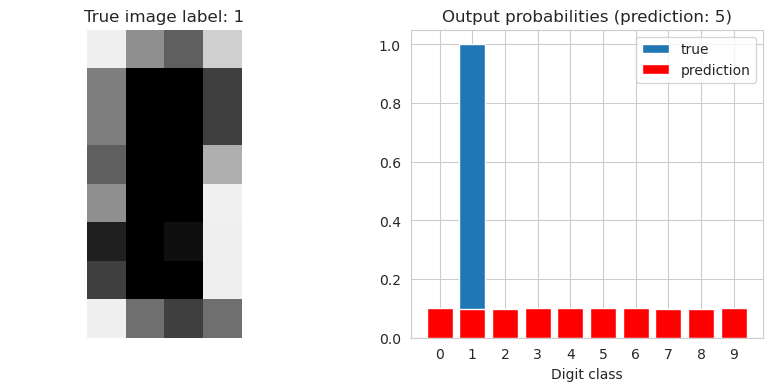

In [34]:
plot_prediction(model, sample_idx=5)

### Train the model for several epochs

In [35]:
losses, losses_test, accuracies, accuracies_test = [], [], [], []
losses.append(model.loss(X_train, y_train))
losses_test.append(model.loss(X_test, y_test))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.1)

    losses.append(model.loss(X_train, y_train))
    losses_test.append(model.loss(X_test, y_test))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 2.30249, train acc: 0.099, test acc: 0.115
Epoch #1, train loss: 0.44355, train acc: 0.900, test acc: 0.859
Epoch #2, train loss: 0.20243, train acc: 0.950, test acc: 0.926
Epoch #3, train loss: 0.13095, train acc: 0.975, test acc: 0.933
Epoch #4, train loss: 0.10458, train acc: 0.978, test acc: 0.933
Epoch #5, train loss: 0.08278, train acc: 0.985, test acc: 0.933
Epoch #6, train loss: 0.06727, train acc: 0.988, test acc: 0.944
Epoch #7, train loss: 0.06303, train acc: 0.986, test acc: 0.930
Epoch #8, train loss: 0.07567, train acc: 0.981, test acc: 0.941
Epoch #9, train loss: 0.03687, train acc: 0.996, test acc: 0.952
Epoch #10, train loss: 0.03135, train acc: 0.997, test acc: 0.956
Epoch #11, train loss: 0.02719, train acc: 0.998, test acc: 0.959
Epoch #12, train loss: 0.02392, train acc: 0.998, test acc: 0.959
Epoch #13, train loss: 0.02144, train acc: 0.999, test acc: 0.956
Epoch #14, train loss: 0.01950, train acc: 0.999, test acc: 0.956
Epoch #15, train 

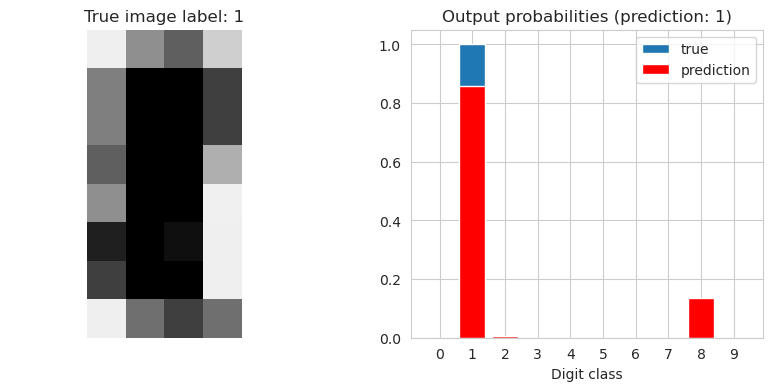

In [36]:
plot_prediction(model, sample_idx=5)

## Loss evolution per epoch

Text(0.5, 1.0, 'Accuracy')

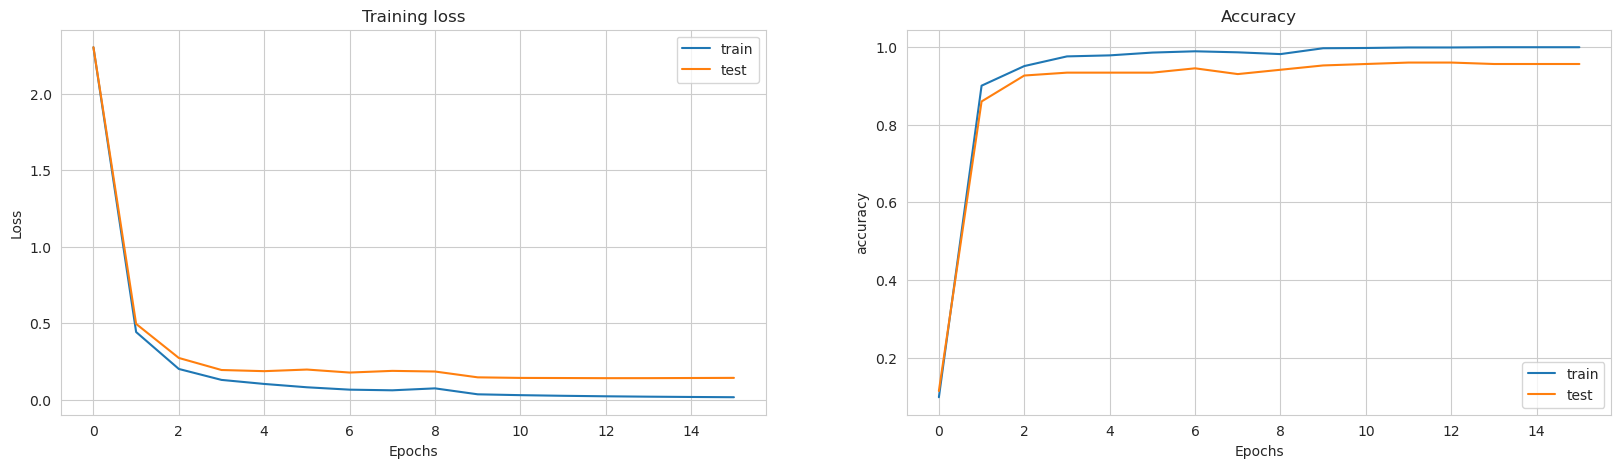

In [37]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
ax.plot(losses,label='train')
ax.plot(losses_test,label='test')
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend(loc='best');
ax.set_title("Training loss");
ax = fig.add_subplot(1,2,2)
ax.plot(accuracies, label='train')
ax.plot(accuracies_test, label='test')
ax.set_ylabel("accuracy")
ax.set_xlabel("Epochs")
ax.legend(loc='best')
ax.set_title("Accuracy")

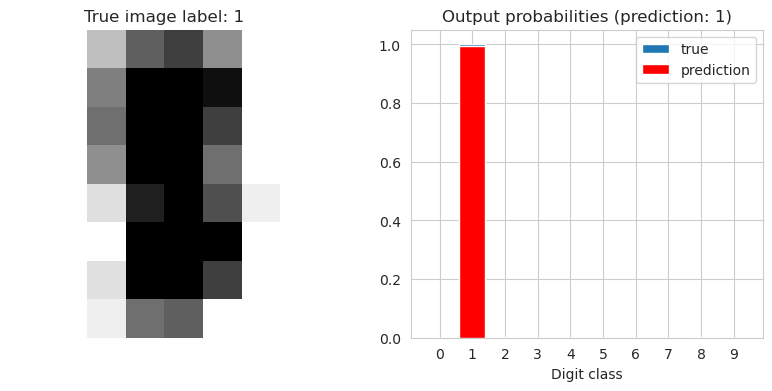

In [38]:
plot_prediction(model, sample_idx=4)

## Tensorflow/keras

### Implement the same multi layer perceptron using Keras

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

n_features = 64
n_classes = 10
n_hidden = 10

2024-04-29 11:10:27.769296: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [40]:
# %load solutions/mlp_keras.py
keras_model = Sequential()
keras_model.add(Dense(n_hidden, input_dim=n_features, activation='sigmoid'))
keras_model.add(Dense(n_classes, activation='softmax'))

keras_model.compile(optimizer=SGD(learning_rate=3),
                    loss='categorical_crossentropy', metrics=['accuracy'])

history = keras_model.fit(X_train, to_categorical(y_train), epochs=15, batch_size=32, validation_data = (X_test, to_categorical(y_test)))

2024-04-29 11:10:46.256773: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/15
48/48 [==============================] - 1s 10ms/step - loss: 0.8470 - accuracy: 0.7472 - val_loss: 0.3851 - val_accuracy: 0.8963
Epoch 2/15
48/48 [==============================] - 0s 5ms/step - loss: 0.2345 - accuracy: 0.9430 - val_loss: 0.1822 - val_accuracy: 0.9630
Epoch 3/15
48/48 [==============================] - 0s 4ms/step - loss: 0.1539 - accuracy: 0.9601 - val_loss: 0.1706 - val_accuracy: 0.9556
Epoch 4/15
48/48 [==============================] - 0s 4ms/step - loss: 0.1132 - accuracy: 0.9705 - val_loss: 0.1537 - val_accuracy: 0.9630
Epoch 5/15
48/48 [==============================] - 0s 4ms/step - loss: 0.0949 - accuracy: 0.9771 - val_loss: 0.1254 - val_accuracy: 0.9741
Epoch 6/15
48/48 [==============================] - 0s 5ms/step - loss: 0.0713 - accuracy: 0.9836 - val_loss: 0.1354 - val_accuracy: 0.9630
Epoch 7/15
48/48 [==============================] - 0s 4ms/step - loss: 0.0627 - accuracy: 0.9862 - val_loss: 0.1305 - val_accuracy: 0.9667
Epoch 8/15
48/48 [=

### Implement a function that produces the same results that the plot_prediction function but with keras model output

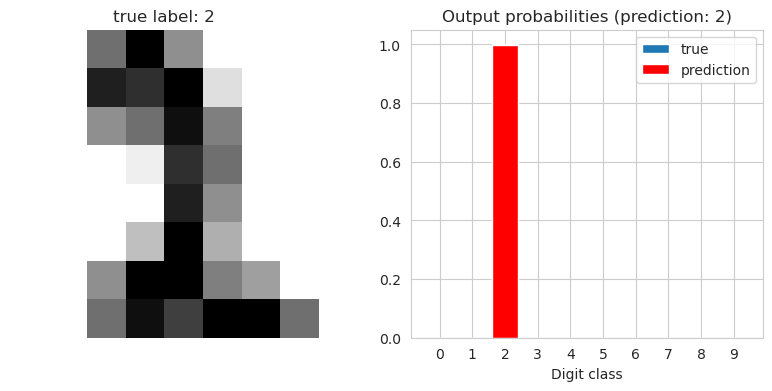

In [41]:
# %load solutions/plot_prediction_keras.py
sample_idx = 28
fig = plt.figure(figsize=(10,4))0.7472
ax = fig.add_subplot(1,2,1)
ax.imshow(scaler.inverse_transform(X_test[sample_idx].reshape(1,-1)).reshape(8, 8),
           cmap=plt.cm.gray_r, interpolation='nearest')
ax.set_title("true label: %d" %y_test[sample_idx])
ax.axis("off")
ax.grid(False)

ax1 = fig.add_subplot(1,2,2)
classes = np.arange(10)
probabilities = keras_model.predict(X_test, verbose=0)
ax1.bar(classes, one_hot(len(classes), y_test[sample_idx]), label='true')
ax1.bar(classes, probabilities[sample_idx], label='prediction', color="red")
ax1.set_xticks(classes)
prediction = model.predict(X_test[sample_idx])
ax1.set_title('Output probabilities (prediction: %d)'
              % prediction)
ax1.set_xlabel('Digit class')
ax1.legend()


### Compare loss and accuracy of keras and numpy

Text(0.5, 1.0, 'Accuracy')

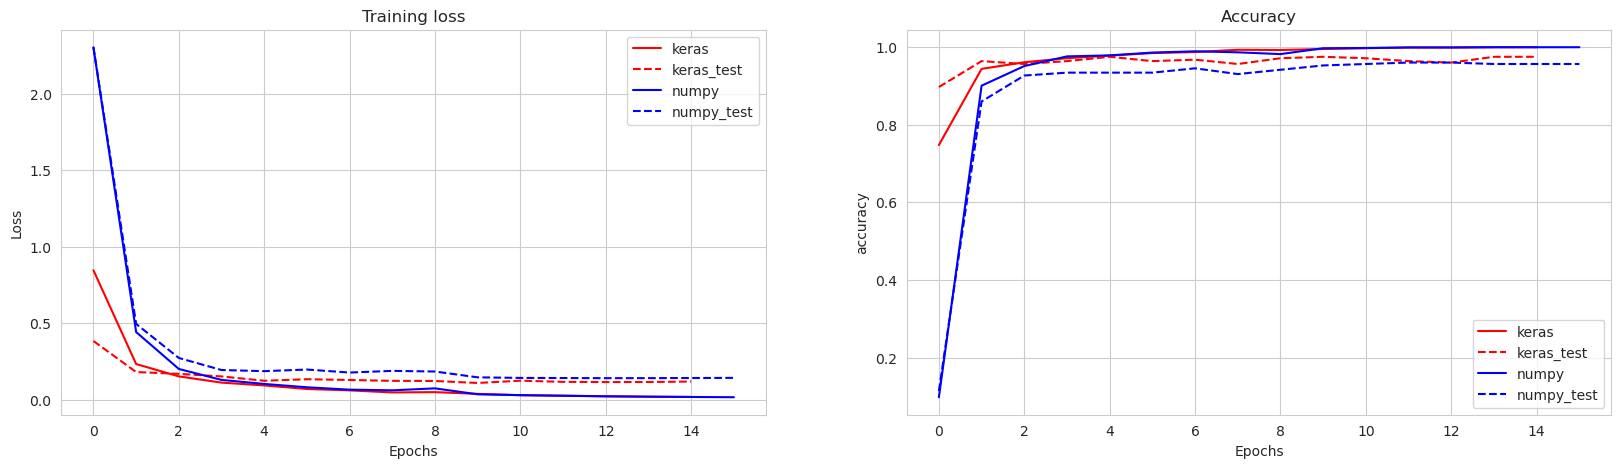

In [42]:
# %load solutions/compare_loss_acc.py
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
ax.plot(history.history["loss"], label="keras", color="red")
ax.plot(history.history["val_loss"], label="keras_test", linestyle="dashed" ,color="red")
ax.plot(losses, label="numpy", color="blue")
ax.plot(losses_test, label="numpy_test", color="blue", linestyle="dashed")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Training loss")
ax.legend(loc='best')
ax = fig.add_subplot(1,2,2)
ax.plot(history.history["accuracy"], label="keras", color="red")
ax.plot(history.history["val_accuracy"], label="keras_test", linestyle="dashed" ,color="red")
ax.plot(accuracies, label="numpy", color="blue")
ax.plot(accuracies_test, label="numpy_test", color="blue", linestyle="dashed")
ax.set_ylabel("accuracy")
ax.set_xlabel("Epochs")
ax.legend(loc='best')
ax.set_title("Accuracy")